#**Unsupervised pre-training vs Data Augmentation**

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cuda:0


In [13]:
n_train = 8000
n_test = 500

batch_size_train = 300
batch_size_test = n_test

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[n_train:(n_train + n_test)], dataset_test.targets[n_train:(n_train + n_test)]
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)

In [15]:
len(dataset_test.data)

500

*Restore model used for unsupervised pre-training*

In [4]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy



def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100



def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)

In [5]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


In [6]:
! mkdir /content/.checkpoints

mkdir: cannot create directory ‘/content/.checkpoints’: File exists


In [7]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

MODEL_PATH = "models/autoencoder/"

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1),  # 28 x 28 x 8 -> 28 x 28 x 1
                                      nn.Sigmoid())  # Usa Sigmoid per ottenere valori tra 0 e 1

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = Autoencoder(input_dim, out_dim).to(device)


In [8]:
pretrained_autoencoder = model
pretrained_autoencoder.load_state_dict(torch.load('model.pth'))
# pretrained_autoencoder.eval()

<All keys matched successfully>

In [9]:
from torchsummary import summary

# Usare la funzione summary per visualizzare un riassunto del modello
summary(pretrained_autoencoder, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             292
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
            Conv2d-7              [-1, 4, 7, 7]             148
              ReLU-8              [-1, 4, 7, 7]               0
          Upsample-9            [-1, 4, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             296
             ReLU-11            [-1, 8, 14, 14]               0
         Upsample-12            [-1, 8, 28, 28]               0
           Conv2d-13            [-1, 1, 28, 28]              73
          Sigmoid-14            [-1, 1,

In [10]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Estraggo l'encoder dal modello preaddestrato
        encoder = pretrained_autoencoder.encoder

        # Appplico il softmax come ultimo layer
        self.encoder_with_softmax = nn.Sequential(
            encoder,
            nn.Flatten(),
            nn.Linear(in_features = (4 * 7 * 7), out_features = 10),
            nn.Softmax(dim = 1)  # Applica softmax lungo la dimensione 1
        )


    def forward(self, x):

        x = self.encoder_with_softmax(x)
        return x

model = EncoderWithSoftmax(pretrained_autoencoder).to(device)
loss_function = nn.CrossEntropyLoss()

In [16]:
train_losses = []
train_accuracies = []
test_accuracies = []
ratio = 12

for i in range (1,ratio):

    n_train_loop = int(n_train * i / ratio)
    batch_size_train_loop = int(batch_size_train * i / ratio)
    dataset_train =  torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)
    dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, drop_last=True)

    EPOCHS = 101
    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')

    #model = EncoderWithSoftmax(pretrained_autoencoder).to(device)

    for epoch in range(1,EPOCHS):
        train_loss = 0

        for x_train, y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            loss = train(model, x_train, y_train)
            train_loss += loss

        train_loss /= len(train_loader)                    # we divide by the number of batches
        train_losses.append(train_loss)

    ## TEST STEP

        if epoch % 100 == 0:
            train_acc, test_acc = evaluate(model, train_loader, test_loader)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print("Epoch:", epoch, "Loss:", float(train_loss), "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        if early_stopping.early_stop:
            train_acc, test_acc = evaluate(model, train_loader, test_loader)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print("Early stopping triggered.")
            break

Epoch: 100 Loss: 1.7921144366264343 data: 666 train_acc 67.66666769981384 test_acc 61.2000048160553
Epoch: 100 Loss: 1.7841205298900604 data: 1333 train_acc 67.33333468437195 test_acc 60.600000619888306
Epoch: 100 Loss: 1.78602401415507 data: 2000 train_acc 67.55556464195251 test_acc 60.80000400543213
Epoch: 100 Loss: 1.778942883014679 data: 2666 train_acc 68.08333992958069 test_acc 63.80000114440918
Epoch: 100 Loss: 1.777022816918113 data: 3333 train_acc 68.30303072929382 test_acc 64.20000195503235
Epoch: 100 Loss: 1.7721618872422438 data: 4000 train_acc 68.3846116065979 test_acc 65.00000357627869
Epoch: 100 Loss: 1.7705705642700196 data: 4666 train_acc 68.86667609214783 test_acc 66.00000262260437
Epoch: 100 Loss: 1.7667145448572494 data: 5333 train_acc 68.8235342502594 test_acc 66.40000343322754
Epoch: 100 Loss: 1.7674008131027221 data: 6000 train_acc 69.0833330154419 test_acc 67.20000505447388
Epoch: 100 Loss: 1.7672707655213096 data: 6666 train_acc 69.15152668952942 test_acc 67.600

In [ ]:
len(test_accuracies)

11

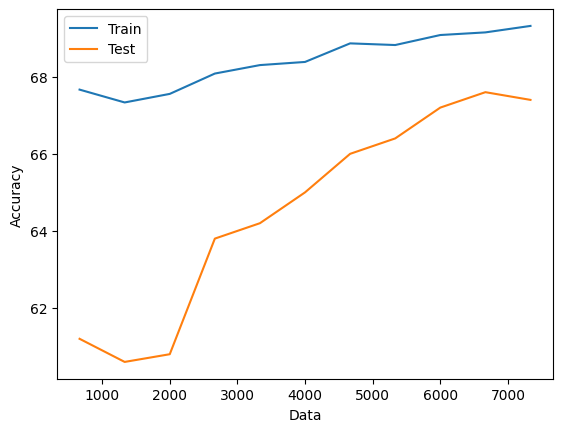

In [17]:
data = [n_train * i/ratio for i in range(1, ratio)]

plt.plot(data, train_accuracies, label = "Train")
plt.plot(data, test_accuracies, label = "Test")

plt.xlabel("Data")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

In [16]:
n_train = 2000
n_test = 500

batch_size_train = 300
batch_size_test = n_test

dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train, shuffle = True,  drop_last = True)

EPOCHS = 100

train_losses = []
train_accuracies = []
test_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

    train_loss = 0

  ## TRAIN STEP

    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        loss = train(model, x_train, y_train)
        train_loss += loss

    train_loss /= len(train_loader)                    # we divide by the number of batches
    train_losses.append(train_loss)

  ## TEST STEP

    if epoch % 10 == 0:

        train_acc, test_acc = evaluate(model, train_loader, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print("Epoch:", epoch, "Loss:", float(train_loss), "train_acc:", train_acc, "test_acc:", test_acc)


Epoch: 0 Loss: 1.654818594455719 train_acc: 81.00000619888306 test_acc: 76.8500030040741
Epoch: 10 Loss: 1.6589344143867493 train_acc: 80.44445514678955 test_acc: 76.75000429153442
Epoch: 20 Loss: 1.6550836165746052 train_acc: 80.83333373069763 test_acc: 76.80000066757202
Epoch: 30 Loss: 1.652099847793579 train_acc: 80.83333373069763 test_acc: 76.8500030040741
Epoch: 40 Loss: 1.6523290276527405 train_acc: 80.61110973358154 test_acc: 76.75000429153442
Epoch: 50 Loss: 1.6509932676951091 train_acc: 80.61110973358154 test_acc: 76.80000066757202
Epoch: 60 Loss: 1.6485671798388164 train_acc: 80.5555522441864 test_acc: 76.60000324249268
Epoch: 70 Loss: 1.6448803544044495 train_acc: 81.27777576446533 test_acc: 76.45000219345093
Epoch: 80 Loss: 1.654762824376424 train_acc: 80.83333373069763 test_acc: 76.5500009059906
Epoch: 90 Loss: 1.6436495780944824 train_acc: 80.55555820465088 test_acc: 76.60000324249268


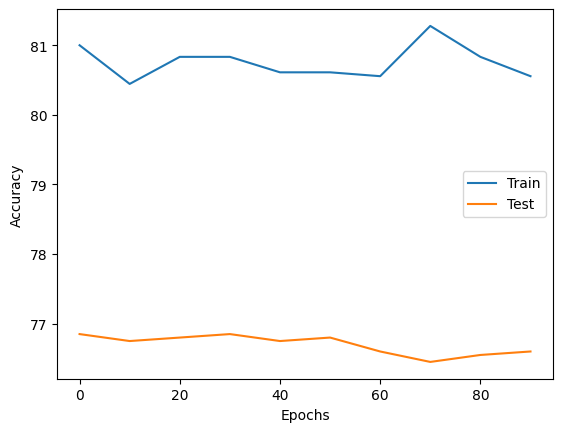

In [17]:
epochs = [i*10 for i in range(EPOCHS//10)]

plt.plot(epochs, train_accuracies, label = "Train")
plt.plot(epochs, test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.legend()

plt.show()